In [1]:
from nn_toxic_words_classifier import train_model
from nn_toxic_words_classifier import load_model

# model = train_model()
# Or load the weights:
model = load_model()

In [2]:
import pandas as pd

dataset_path = '/Users/damirabdulaev/Downloads/filtered.tsv'
df = pd.read_csv(dataset_path, sep='\t')
df = df[(df['similarity'] > 0.8) & (df['ref_tox'] > df['trn_tox'])]
df.head(5)

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
22,22,"Real life starts the first time you fuck, kid.","boy, real life starts up first.",0.866697,0.319149,0.998222,0.000114
29,29,"Hey, leave the poor bastard alone!",leave the poor man alone!,0.857554,0.257143,0.999382,0.000578
41,41,It told you this was a waste of my fucking time.,I told you this was a waste of my time.,0.904062,0.183673,0.995877,0.000479
43,43,"I swear to God, the best thing I ever did in m...","I swear to God, the best thing I've ever done ...",0.932305,0.022472,0.999071,0.000900
48,48,The guy is totally irresponsible.,he's completely irresponsible.,0.862266,0.088235,0.643680,0.019941


In [3]:
from nn_toxic_words_classifier import build_tokenizer
import string
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

tokenizer = build_tokenizer()[0]

recon = []

# Extract and process the first 5 sentences
sentences = df['reference'].tolist()

# Define a threshold for toxic word prediction (adjust as needed)
toxic_threshold = 0.8
temp = 0

# Define a set of punctuation marks
punctuation_set = set(string.punctuation)

model.eval()

# Process and replace toxic words
for sentence in tqdm(sentences):
    encoded_dict = tokenizer(sentence)
    tokens = encoded_dict['input_ids']
    masked_sentence = []

    # Initialize a flag to exclude special tokens
    exclude_special_tokens = True

    for token in tokens:
        # Check if the token is a special token (CLS or SEP)
        is_special_token = token in (tokenizer.cls_token_id, tokenizer.sep_token_id)

        if exclude_special_tokens and is_special_token:
            continue  # Skip special tokens
        else:
            # Convert the token to an index using your vocabulary mapping
            inputs = torch.tensor([token], dtype=torch.long)
            with torch.no_grad():
                outputs = model(inputs)
                predicted_prob = outputs.item()
                # Check if the token is a punctuation mark
                is_punctuation = tokenizer.convert_ids_to_tokens(token) in punctuation_set
                if predicted_prob > toxic_threshold and not is_punctuation:
                    masked_sentence.append(1008)
                else:
                    masked_sentence.append(token)

    # Use tokenizer.decode to reconstruct the sentence
    reconstructed_sentence = tokenizer.decode(masked_sentence)

    # Print the original sentence and the reconstructed sentenc
    recon.append((sentence, reconstructed_sentence))

100%|██████████| 108569/108569 [00:41<00:00, 2600.40it/s]


In [4]:
from J_metric import J

# Extract the pairs of sentences from the tuples
original = [sentence[0] for sentence in recon[:1000]]
detox = [sentence[1] for sentence in recon[:1000]]

result = J(original, detox)  # Call the J function with appropriate arguments

Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:32<00:00, 30.47it/s]


0.7788414127813085
Calculate the semantic similarity
0.7077348559945822
Calculating CoLA acceptability stats


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9271976281367242
| ACC | SIM | FL | J |

|0.7788|0.7077|0.9272|0.5111|



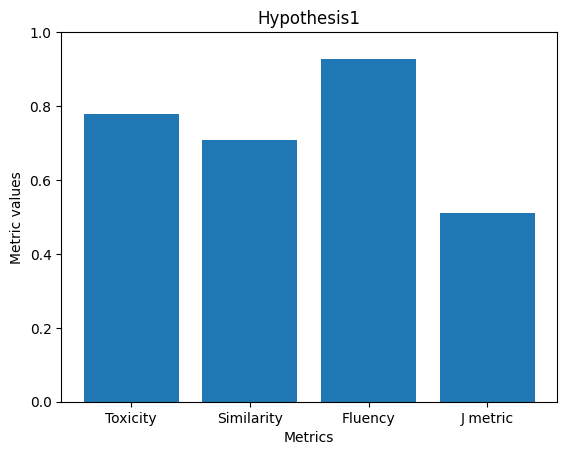

In [5]:
from bar_chart_for_metric import build_chart

data = [0.7788, 0.7077, 0.9272, 0.5111]

build_chart(data, "Hypothesis1", '/Users/damirabdulaev/Desktop/Hypothesis1.png')